In [1]:
# 收在下布林，且下影線大於實體Ｋ及上影線，加入EMA
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1641002583000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

                Close_Time     Open    Close     High      Low      Volume
0      2022-01-01 11:59:59  3728.41  3723.96  3737.00  3721.84   3543.1853
1      2022-01-01 12:59:59  3723.96  3708.21  3728.07  3707.24   6117.2820
2      2022-01-01 13:59:59  3708.20  3735.61  3765.27  3702.84   9353.2056
3      2022-01-01 14:59:59  3735.60  3711.92  3742.67  3708.33   5239.0026
4      2022-01-01 15:59:59  3711.93  3715.31  3724.93  3701.00   6541.6499
...                    ...      ...      ...      ...      ...         ...
10747  2023-03-25 07:59:59  1743.27  1749.57  1753.87  1742.22  16307.1125
10748  2023-03-25 08:59:59  1749.57  1756.33  1758.41  1746.48  13545.4908
10749  2023-03-25 09:59:59  1756.32  1753.88  1757.07  1748.82  10968.0535
10750  2023-03-25 10:59:59  1753.88  1758.66  1762.43  1753.18  10659.0821
10751  2023-03-25 11:59:59  1758.65  1756.98  1759.00  1756.52   2185.4378

[10752 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
#     ema
    ema_int = 200
    df['ema'] = ta.trend.ema_indicator(df.Close, window=ema_int)
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema
0,2022-01-01 11:59:59,3728.41,3723.96,3737.00,3721.84,3543.1853,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 12:59:59,3723.96,3708.21,3728.07,3707.24,6117.2820,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01 13:59:59,3708.20,3735.61,3765.27,3702.84,9353.2056,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01 14:59:59,3735.60,3711.92,3742.67,3708.33,5239.0026,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01 15:59:59,3711.93,3715.31,3724.93,3701.00,6541.6499,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10747,2023-03-25 07:59:59,1743.27,1749.57,1753.87,1742.22,16307.1125,1789.286667,1844.068408,1789.286667,1734.504925,39.727957,1751.191829
10748,2023-03-25 08:59:59,1749.57,1756.33,1758.41,1746.48,13545.4908,1786.951000,1841.176303,1786.951000,1732.725697,43.100881,1751.242955
10749,2023-03-25 09:59:59,1756.32,1753.88,1757.07,1748.82,10968.0535,1785.347667,1840.536526,1785.347667,1730.158807,42.179589,1751.269195
10750,2023-03-25 10:59:59,1753.88,1758.66,1762.43,1753.18,10659.0821,1783.275000,1837.640705,1783.275000,1728.909295,44.664776,1751.342735


In [9]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c1_1 紅Ｋ
    # c1_2 綠Ｋ
    # c2 收盤 小於 布林下
    # c3 ema 200

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (df['Open'] > df['Close']) & (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (df['Close'] > df['Open']) & (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']
        # c3
        df['c3'] = df['Close'] <= df['ema']

    # 條件達成
    df['signal'] = False
    df.loc[(df['c1_1'] | df['c1_2']) & df.c2 & df.c3, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema,c1_1,c1_2,c2,c3,signal,openbuy
0,2022-01-01 11:59:59,3728.41,3723.96,3737.00,3721.84,3543.1853,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,2022-01-01 12:59:59,3723.96,3708.21,3728.07,3707.24,6117.2820,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
2,2022-01-01 13:59:59,3708.20,3735.61,3765.27,3702.84,9353.2056,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,2022-01-01 14:59:59,3735.60,3711.92,3742.67,3708.33,5239.0026,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,2022-01-01 15:59:59,3711.93,3715.31,3724.93,3701.00,6541.6499,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,2023-03-25 07:59:59,1743.27,1749.57,1753.87,1742.22,16307.1125,1789.286667,1844.068408,1789.286667,1734.504925,39.727957,1751.191829,False,False,False,True,False,False
10748,2023-03-25 08:59:59,1749.57,1756.33,1758.41,1746.48,13545.4908,1786.951000,1841.176303,1786.951000,1732.725697,43.100881,1751.242955,False,False,False,False,False,False
10749,2023-03-25 09:59:59,1756.32,1753.88,1757.07,1748.82,10968.0535,1785.347667,1840.536526,1785.347667,1730.158807,42.179589,1751.269195,True,False,False,False,False,False
10750,2023-03-25 10:59:59,1753.88,1758.66,1762.43,1753.18,10659.0821,1783.275000,1837.640705,1783.275000,1728.909295,44.664776,1751.342735,False,False,False,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


                Close_Time     Open    Close     High      Low       Volume  \
227    2022-01-10 22:59:59  3021.34  3018.96  3041.82  2928.83  128141.5663   
228    2022-01-10 23:59:59  3018.96  3006.26  3032.40  2981.03   40379.5084   
229    2022-01-11 00:59:59  3006.27  3075.74  3095.00  2996.10   43620.2713   
253    2022-01-12 00:59:59  3133.55  3218.67  3237.22  3130.00   67296.1494   
302    2022-01-14 01:59:59  3301.24  3281.71  3304.33  3249.00   25448.0879   
...                    ...      ...      ...      ...      ...          ...   
10266  2023-03-05 05:59:59  1557.65  1557.07  1560.64  1549.27   19216.2909   
10270  2023-03-05 09:59:59  1570.15  1582.11  1588.77  1567.70   43125.1370   
10337  2023-03-08 04:59:59  1551.26  1548.20  1553.02  1543.10   22835.1524   
10338  2023-03-08 05:59:59  1548.20  1550.50  1555.18  1544.20   28465.7691   
10364  2023-03-09 07:59:59  1545.59  1532.38  1548.19  1523.61   58596.2112   

               sma         bb_u         bb_m       

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = df['position'].str.count('Sell').sum()
loses = df['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low          sma  \
0    2022-01-10 23:59:59  3018.96  3006.26  3032.40  2981.03  3130.832333   
1    2022-01-11 00:59:59  3006.27  3075.74  3095.00  2996.10  3129.797000   
2    2022-01-12 00:59:59  3133.55  3218.67  3237.22  3130.00  3087.766000   
3    2022-01-14 02:59:59  3281.40  3270.59  3296.49  3265.98  3350.109667   
4    2022-01-14 04:59:59  3271.49  3275.81  3278.73  3233.43  3343.479000   
..                   ...      ...      ...      ...      ...          ...   
275  2023-03-04 02:59:59  1572.16  1559.82  1573.38  1550.75  1594.821667   
276  2023-03-05 05:59:59  1557.65  1557.07  1560.64  1549.27  1566.469333   
277  2023-03-05 09:59:59  1570.15  1582.11  1588.77  1567.70  1566.939333   
278  2023-03-08 05:59:59  1548.20  1550.50  1555.18  1544.20  1565.976667   
279  2023-03-09 07:59:59  1545.59  1532.38  1548.19  1523.61  1554.823000   

            bb_u         bb_l        rsi position  entry_p  stop_loss  size

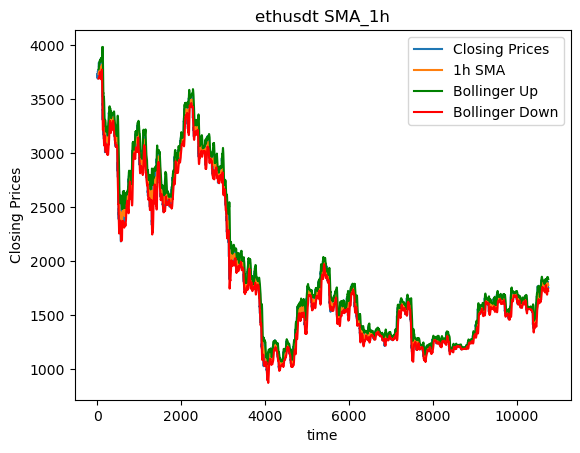

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(interval) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()